<h1>NBA Allstars predictions</h1>

In [2]:
import sys
import subprocess

packages = [
    "numpy",
    "nba_api",
    "pandas",
    "unidecode",
    "scikit-learn",
    "imbalanced-learn",
    "xgboost",
    "matplotlib",
    "tqdm"
]

for package in packages:
    subprocess.run([sys.executable, "-m", "pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("install complete")


install complete


<h2>Step1: collecting datas</h2>

To gather career statistics of players who played in the NBA, I used the NBA API.  
Link: [https://github.com/swar/nba_api?tab=readme-ov-file](https://github.com/swar/nba_api?tab=readme-ov-file)

Using this API, I obtained the `player_id` of all registered players and requested the career stats for each player to create a DataFrame. The career stats of each player consist of the following features:  
["PLAYER_ID", "SEASON_ID", "LEAGUE_ID", "TEAM_ID", "TEAM_ABBREVIATION", "PLAYER_AGE",  
"GP", "GS", "MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT",  
"OREB", "DREB", "REB", "AST", "STL", "BLK", "TOV", "PF", "PTS"].  

These features will later be used to train an algorithm that predicts whether a player is selected as an All-Star. When using the NBA API, sending too many requests to the NBA website resulted in timeout errors. To address this, I created a function called `fetch_player_data` that retries requests with progressively longer `sleeptime` values up to a maximum of five attempts. This function allowed me to consolidate all players' career stats into a single DataFrame, which was then saved as a CSV file.  

In [1]:
import pandas as pd
import time
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
import warnings
from tqdm import tqdm 

warnings.filterwarnings('ignore', category=FutureWarning)

def fetch_player_data(player_id, retries=5, initial_sleep_time=1):
    """
    function to get career of certain player_id
    
    Args:
        player_id (int): Player_id of NBA player
        retries (int): Maximum number of retries
        initial_sleep_time (int): The time (in seconds) to wait before the first retry.
        
    Returns:
        pd.DataFrame: Player career dataframe or None.
    """
    sleep_time = initial_sleep_time
    
    for attempt in range(retries):
        try:
            # request player career
            career = playercareerstats.PlayerCareerStats(player_id=player_id)
            career_df = career.get_data_frames()[0] 

            return career_df
        
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(sleep_time)
                sleep_time += 1

    return None

# get all players
players = players.get_players()

# get id of all players(5034 players)
ids = [player["id"] for player in players]

#create empty dataframe
columns = ["PLAYER_ID", "SEASON_ID", "LEAGUE_ID", "TEAM_ID", "TEAM_ABBREVIATION", "PLAYER_AGE",
           "GP", "GS", "MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT",
           "OREB", "DREB", "REB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
all_career = pd.DataFrame(columns=columns)

print("start fetching players...")

# tqdm을 사용하여 진행 상황 표시
for player_id in tqdm(ids, desc="Fetching Players", unit="player"):
    data = fetch_player_data(player_id)
    if data is not None: 
        all_career = pd.concat([all_career, data], ignore_index=True)

print("all datas:", all_career.head())
all_career.to_csv("all_career.csv", index=False, encoding="utf-8")

print("successfully saved as CSV file: all_career.csv")


start fetching players...


Fetching Players: 100%|█████████████████████████████████████████████████████| 5034/5034 [12:58:47<00:00,  9.28s/player]

all datas:   PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  GP  \
0     76001   1990-91        00  1610612757               POR        23.0  43   
1     76001   1991-92        00  1610612757               POR        24.0  71   
2     76001   1992-93        00  1610612749               MIL        25.0  12   
3     76001   1992-93        00  1610612738               BOS        25.0  63   
4     76001   1992-93        00           0               TOT        25.0  75   

   GS     MIN  FGM  ... FT_PCT  OREB DREB  REB  AST STL BLK  TOV   PF  PTS  
0   0   290.0   55  ...  0.568    27   62   89   12   4  12   22   39  135  
1   1   934.0  178  ...  0.752    81  179  260   30  25  16   66  132  432  
2   0   159.0   26  ...  0.750    12   25   37   10   6   4   13   24   64  
3  52  1152.0  219  ...  0.760   114  186  300   17  19  22   84  165  514  
4  52  1311.0  245  ...  0.759   126  211  337   27  25  26   97  189  578  

[5 rows x 27 columns]
successfully save

<h2>Step2: merge allstar.csv into all_career.csv</h2>

I downloaded a table from Kaggle that lists which players were selected as All-Stars for each year.  
Link: [https://www.kaggle.com/datasets/ethankeyes/nba-all-star-players-and-stats-1980-2022](https://www.kaggle.com/datasets/ethankeyes/nba-all-star-players-and-stats-1980-2022)

To seamlessly connect the data from `allstar.csv` and `all_career.csv`, I preprocessed the values in `all_career.csv`. Since `allstar.csv` contains All-Star lists only from 1980 onwards, I removed players from `all_career.csv` who played before 1980. Additionally, the `all_career` table identifies players by their ID, while `allstar_df` identifies players by their names without player IDs. To address this, I used the `find_player_by_id` function to find the first and last names of players based on their `player_id`, removed special characters, and added these names as a new column. I also unified the team abbreviations in both dataframes.

Furthermore, the year format in `all_career` is represented as "1990-91", while in `allstar`, it is stored as "1990". Therefore, I converted the years in `all_career` to the earlier year of the range. Lastly, I added a target column called `allstar`.

After these modifications, if a player from `all_career` was selected as an All-Star in a given year, I set the value of the `allstar` column to `1`; otherwise, I set it to `0`. For the years 2023 and 2024, I manually found the relevant players and set their `allstar` column values to `1`.


In [1]:
def drop_columns_if_exist(df, columns):
    # Filter only the columns that exist in the DataFrame
    existing_columns = [col for col in columns if col in df.columns]
    if existing_columns:
        df.drop(columns=existing_columns, inplace=True)
        print(f"Removed columns: {existing_columns}")
    else:
        print("No specified columns to remove.")

        # fetch player name function
def fetch_player_name(player_id, retries=5, initial_sleep_time=1):
    """
    Fetch player first_name and last_name by player_id.

    Args:
        player_id (int): Player ID to fetch.
        retries (int): Maximum number of retries.
        initial_sleep_time (int): Initial sleep time in seconds.

    Returns:   
        dict: A dictionary containing 'first_name' and 'last_name', or None if failed.
    """
    sleep_time = initial_sleep_time
    for attempt in range(retries):
        try:
            player_info = players.find_player_by_id(player_id)
            if player_info:
                # Convert names to standard English alphabets using unidecode
                first_name = unidecode(player_info["first_name"])
                last_name = unidecode(player_info["last_name"])
                return {"first_name": first_name, "last_name": last_name}
            else:
                print(f"No data found for player_id {player_id}.")
                return None
        except Exception as e:
            print(f"Error fetching player_id {player_id}: {e}")
            if attempt < retries - 1:
                time.sleep(sleep_time)
                sleep_time += 1
            else:
                print(f"Failed to fetch name for player_id {player_id} after {retries} attempts.")
    return None

In [2]:
import pandas as pd

# allstar dataframe and all career dataframe
allstar_df = pd.read_csv("allstar.csv")
all_career = pd.read_csv("all_career.csv")

#rename the column "TEAM_AABREVIATION" to "team"
all_career.rename(columns={"TEAM_ABBREVIATION": "team"}, inplace=True)

# Extract only the first 4 digits of the SEASON_ID column
all_career["SEASON_ID"] = all_career["SEASON_ID"].str.slice(0, 4)

# Leave only data with SEASON_ID value greater than 1980
all_career = all_career[all_career["SEASON_ID"].astype(int) >= 1980]

all_career.rename(columns={"SEASON_ID": "year"}, inplace=True)

#remove unnecessary columns
drop_columns_if_exist(all_career, ["LEAGUE_ID", "TEAM_ID"])

# list of teamname sin allstar dataframe
allstar_teams = allstar_df["team"].unique().tolist()

# list of teamnames in all_career dataframe
career_teams = all_career["team"].unique().tolist()

# list of teamname which is included in allstar, but not in all_career
allstar_unique_teams = [team for team in allstar_teams if team not in career_teams]
print(allstar_unique_teams)

#Unifying team abbreviations in two data frames
all_career["team"] = all_career["team"].replace({
    "PHL": "PHI",
    "PHX": "PHO",
    "WAS": "WSB",
    "CHA": "CHO"
})
print("succesfully updated teamnames")

all_career.to_csv("all_career_1980.csv", index=False, encoding="utf-8")
print("successfully saved all_career_1980.csv" )

Removed columns: ['LEAGUE_ID', 'TEAM_ID']
['PHO', 'WSB', 'BRK', 'CHO']
succesfully updated teamnames
successfully saved all_career_1980.csv


In [3]:
import pandas as pd
import time
from nba_api.stats.static import players
from unidecode import unidecode 
import warnings

# read csv file
career_1980 = pd.read_csv("all_career_1980.csv")
    

# add 'first' and 'last' column 
career_1980["first"] = None
career_1980["last"] = None

# add first and last name of players
for index, row in career_1980.iterrows():
    player_id = row["PLAYER_ID"]
    player_name = fetch_player_name(player_id)
    if player_name:
        career_1980.at[index, "first"] = player_name["first_name"]
        career_1980.at[index, "last"] = player_name["last_name"]

# Define the order of columns to change
columns_order = ['PLAYER_ID', 'first', 'last'] + [col for col in career_1980.columns if col not in ['PLAYER_ID', 'first', 'last']]

# Change column order
career_1980 = career_1980[columns_order]

# save updated dataframe
career_1980.to_csv("all_career_1980_updated.csv", index=False, encoding="utf-8")
print("successfully saved all_career_1980_updated.csv")


successfully saved all_career_1980_updated.csv


In [4]:
import pandas as pd

# Cread CSV file
career_1980_updated = pd.read_csv("all_career_1980_updated.csv")
allstar = pd.read_csv("allstar.csv")

# allstar column initialization (default 0)
career_1980_updated["allstar"] = 0

# Merge based on first, last, year columns
merged_df = career_1980_updated.merge(
    allstar[["first", "last", "year", "team"]],  
    how="left",                        
    on=["first", "last", "year","team"],        
    indicator=True          
)

# Update allstar values ​​in merged data (1 for matching rows, 0 otherwise)
career_1980_updated["allstar"] = (merged_df["_merge"] == "both").astype(int)

# save updated dataframe
career_1980_updated.to_csv("all_career_1980_allstar_updated.csv", index=False, encoding="utf-8")
print("successfully saved all_career_1980_allstar_updated.csv")



successfully saved all_career_1980_allstar_updated.csv


<h2>Step3: Data Preprocessing</h2>
<h3>Handling Missing value</h3>
Upon review, missing values were identified in the first, GS, FG_PCT, FG3_PCT, and FT_PCT col  mns. The player's first name was deemed insignificant to the analysis and thus ignored. For the remaining missing values, if data from the player's previous and subsequent seasons was available, the missing value was filled with the average of those values. If such data was unavailable, the corresponding row was removed to handle all missing values.

In [29]:
import pandas as pd

# read CSV file
df = pd.read_csv("all_career_1980_allstar_updated.csv")

# Check if there is an empty value (NaN)
missing_values = df.isnull()

# Output row indices of empty values ​​in each column
columns_with_missing_values = [column for column in df.columns if df[column].isnull().any()]
print(columns_with_missing_values)

# Handling missing values
for column in ['GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT']:
    for index in df[df[column].isnull()].index:
        prev_season = df.loc[index - 1, column] if index - 1 in df.index else None
        next_season = df.loc[index + 1, column] if index + 1 in df.index else None

        if pd.notnull(prev_season) and pd.notnull(next_season):
            df.at[index, column] = (prev_season + next_season) / 2
        elif pd.notnull(prev_season):
            df.at[index, column] = prev_season
        elif pd.notnull(next_season):
            df.at[index, column] = next_season
        else:
            df.drop(index, inplace=True)


#save updated dataframe
df.to_csv("all_career_without_missing_value.csv", index=False)

print("Missing values have been handled and the updated DataFrame has been saved.")

['first', 'GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT']
Missing values have been handled and the updated DataFrame has been saved.


<h3>One-Hot Encoding, Data Scaling ,SMOTE</h3>
The `team` column, being the only categorical data, was encoded into numerical values using one-hot encoding.  
The remaining numerical features were scaled using `StandardScaler`, which is suitable for classification tasks.  
To address the class imbalance problem, **SMOTE (Synthetic Minority Oversampling Technique)** was applied to generate synthetic samples for the minority class (1, All-Star), augmenting the dataset.



In [16]:
!pip install -U imbalanced-learn==0.14.0
!pip install -U scikit-learn==1.7.1 imbalanced-learn==0.14.0


  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# read CSV file
df = pd.read_csv("all_career_without_missing_value.csv")

# One-Hot Encoding
df = pd.get_dummies(df, columns=['team'], prefix=['team'])

# StandardScaler
scaler = StandardScaler()
numerical_columns = [ "year", "PLAYER_AGE",  
"GP", "GS", "MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT",  
"OREB", "DREB", "REB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# setting targetvalue
X = df.drop(columns=['PLAYER_ID','first','last','allstar'])
y = df['allstar']

# Handling imbalanced data (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# save train and test data
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Preprocessing and data split completed!")

Preprocessing and data split completed!


<h3>Step4: Training</h3>

In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# load data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze() 
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()  


def train_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_pred_proba



def train_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_pred_proba




def train_random_forest(X_train, y_train, X_test, save_model_path=None):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # save model
    if save_model_path:
        joblib.dump(model, save_model_path)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_pred_proba


def evaluate_model(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return accuracy, roc_auc

y_pred_xgb, y_pred_proba_xgb = train_xgboost(X_train, y_train, X_test)
y_pred_lr, y_pred_proba_lr = train_logistic_regression(X_train, y_train, X_test)
y_pred_rf, y_pred_proba_rf = train_random_forest(X_train, y_train, X_test, save_model_path='random_forest_model.pkl')


# evaluate XGBoost 
accuracy_xgb, roc_auc_xgb = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb)
print(f"XGBoost - Accuracy: {accuracy_xgb:.4f}, ROC AUC: {roc_auc_xgb:.4f}")

# evaluate Logistic Regression 
accuracy_lr, roc_auc_lr = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr)
print(f"Logistic Regression - Accuracy: {accuracy_lr:.4f}, ROC AUC: {roc_auc_lr:.4f}")

# evaluate Random Forest 
accuracy_rf, roc_auc_rf = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}, ROC AUC: {roc_auc_rf:.4f}")



XGBoost - Accuracy: 0.9778, ROC AUC: 0.9971
Logistic Regression - Accuracy: 0.9719, ROC AUC: 0.9952
Random Forest - Accuracy: 0.9838, ROC AUC: 0.9989


In [25]:
import pandas as pd
X_train = pd.read_csv("X_train.csv")
print(X_train.columns)

Index(['year', 'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'team_ATL', 'team_BKN', 'team_BOS',
       'team_CHH', 'team_CHI', 'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN',
       'team_DET', 'team_GOS', 'team_GSW', 'team_HOU', 'team_IND', 'team_KCK',
       'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN',
       'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP', 'team_NYK', 'team_OKC',
       'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC', 'team_SAN',
       'team_SAS', 'team_SDC', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_UTH', 'team_VAN', 'team_WSB'],
      dtype='object')


<h2>Step5: Prediction</h2>

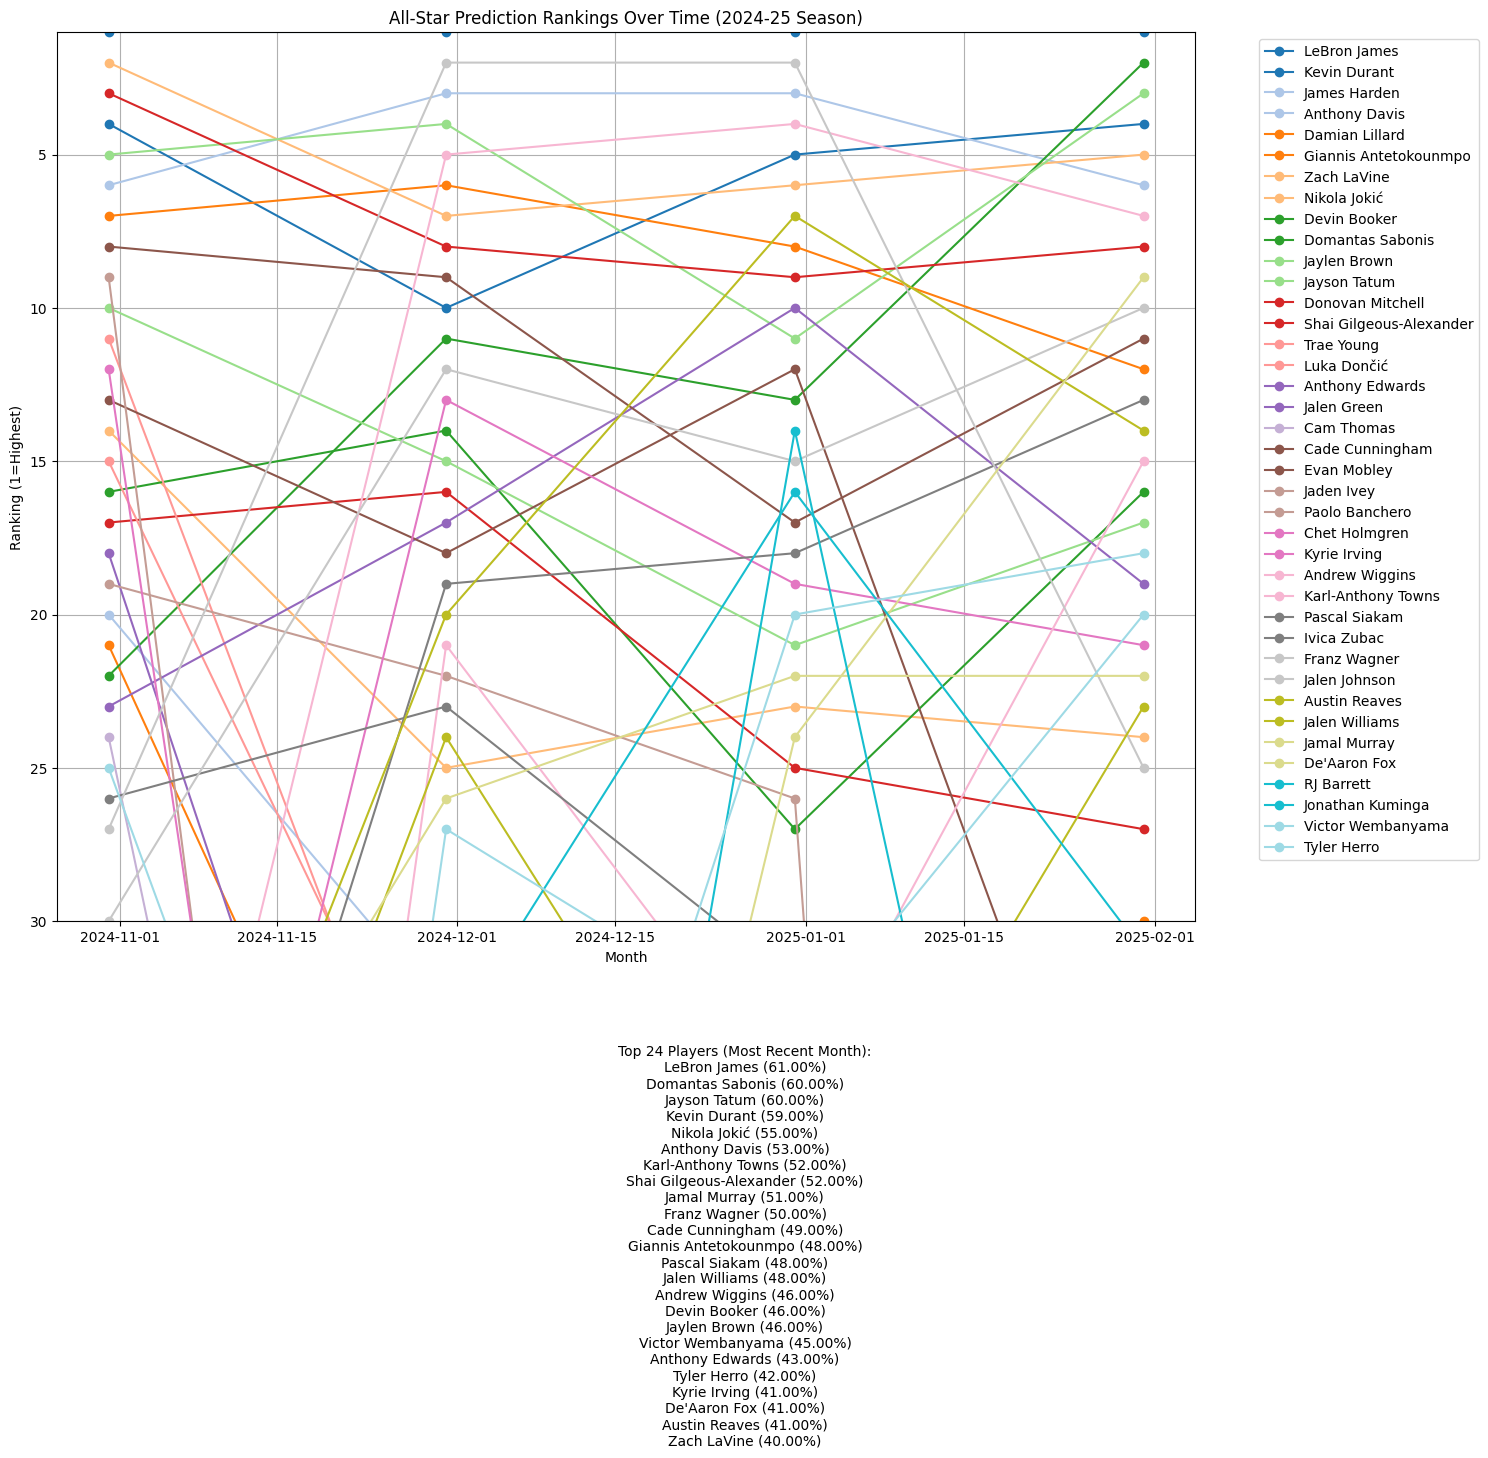

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
from nba_api.stats.endpoints import leaguegamelog
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 1. Load and preprocess data
gamelog = leaguegamelog.LeagueGameLog(season='2024-25', player_or_team_abbreviation='P')
gamelog_df = gamelog.get_data_frames()[0]

# Convert game dates to datetime format
gamelog_df['GAME_DATE'] = pd.to_datetime(gamelog_df['GAME_DATE'])

# Set start date and end date
start_date = datetime(2024, 10, 1)
end_date = datetime(2025, 2, 1)


# Aggregate and preprocess player stats
def preprocess_monthly_data(df, end_date):
    # Filter data up to the specified end date
    filtered_stats = df[df['GAME_DATE'] <= end_date]
    # Group by player and aggregate stats
    grouped = filtered_stats.groupby('PLAYER_ID').agg({
        'PLAYER_NAME': 'first',
        'TEAM_ABBREVIATION': 'first',
        'MIN': 'sum', 'FGM': 'sum', 'FGA': 'sum', 'FG_PCT': 'mean',
        'FG3M': 'sum', 'FG3A': 'sum', 'FG3_PCT': 'mean',
        'FTM': 'sum', 'FTA': 'sum', 'FT_PCT': 'mean',
        'OREB': 'sum', 'DREB': 'sum', 'REB': 'sum', 'AST': 'sum',
        'STL': 'sum', 'BLK': 'sum', 'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'
    }).reset_index()

    # Map team names and perform one-hot encoding
    grouped.rename(columns={"TEAM_ABBREVIATION": "team"}, inplace=True)
    team_mapping = {
        "PHL": "PHI",
        "PHX": "PHO",
        "WAS": "WSB",
        "CHA": "CHO"
    }
    grouped['team'] = grouped['team'].replace(team_mapping)
    team_encoded = pd.get_dummies(grouped['team'], prefix='team')

    # Add columns to match the training data
    grouped = pd.concat([grouped, team_encoded], axis=1)

    # Add one-hot columns for teams not present in the grouped data
    required_columns = [
        'year', 'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
        'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
        'TOV', 'PF', 'PTS', 'team_ATL', 'team_BKN', 'team_BOS', 'team_CHH', 'team_CHI',
        'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GOS', 'team_GSW',
        'team_HOU', 'team_IND', 'team_KCK', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA',
        'team_MIL', 'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP', 'team_NYK',
        'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC', 'team_SAN',
        'team_SAS', 'team_SDC', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA', 'team_UTH',
        'team_VAN', 'team_WSB'
    ]

    # Fill missing columns with 0
    for col in required_columns:
        if col not in grouped.columns:
            grouped[col] = 0

    # Add year column
    grouped['year'] = 2024

    # Scale numerical columns
    numerical_columns = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                         'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                         'STL', 'BLK', 'TOV', 'PF', 'PTS']
    grouped[numerical_columns] = scaler.fit_transform(grouped[numerical_columns])

    # Drop unnecessary columns
    grouped = grouped[['PLAYER_NAME', 'PLAYER_ID'] + required_columns[1:]]

    return grouped

# 2. Load the Random Forest model
rf_model = joblib.load('random_forest_model.pkl')

# 3. Calculate monthly stats and probabilities
dates = pd.date_range(start=start_date, end=end_date, freq='M')
all_results = []

for date in dates:
    monthly_data = preprocess_monthly_data(gamelog_df, date)

    # Add necessary features and sort
    X = monthly_data.drop(['PLAYER_NAME', 'PLAYER_ID'], axis=1)

    # Add missing features with default values
    required_columns = rf_model.feature_names_in_
    for col in required_columns:
        if col not in X.columns:
            X[col] = 0

    # Match column order with training data
    X = X[required_columns]

    # Make predictions
    monthly_data['ALLSTAR_PROB'] = rf_model.predict_proba(X)[:, 1]

    # Add date column
    monthly_data['DATE'] = date
    all_results.append(monthly_data)

# Convert list to DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Filter top 24 players and track players
all_results_df['RANK'] = all_results_df.groupby('DATE')['ALLSTAR_PROB'].rank(ascending=False, method='first')
filtered_players = all_results_df[all_results_df['RANK'] <= 24]

# Track players who were in the top 24 at least once
tracked_players = filtered_players['PLAYER_NAME'].unique()
tracked_data = all_results_df[all_results_df['PLAYER_NAME'].isin(tracked_players)]

# 4. Create a graph
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(np.linspace(0, 1, len(tracked_players)))

for i, player in enumerate(tracked_players):
    player_data = tracked_data[tracked_data['PLAYER_NAME'] == player]
    # Plot points for all dates
    plt.plot(player_data['DATE'], player_data['RANK'], marker='o', linestyle='-', label=player, color=colors[i])

plt.gca().invert_yaxis()  # Lower rank is higher value
plt.ylim(30, 1)  # Limit y-axis to top 30
plt.title('All-Star Prediction Rankings Over Time (2024-25 Season)')
plt.xlabel('Month')
plt.ylabel('Ranking (1=Highest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# 5. Display top 24 players for the most recent month
recent_month = tracked_data['DATE'].max()  # Most recent month
recent_month_data = tracked_data[tracked_data['DATE'] == recent_month]  # Data for that date
top_24_players = recent_month_data.nlargest(24, 'ALLSTAR_PROB')[['PLAYER_NAME', 'ALLSTAR_PROB']]  # Top 24 by probability

# Display top 24 players below the graph
plt.figtext(
    0.5, -0.05,  # Position below the graph
    "Top 24 Players (Most Recent Month):\n" +
    "\n".join(f"{row['PLAYER_NAME']} ({row['ALLSTAR_PROB']:.2%})" for _, row in top_24_players.iterrows()),
    wrap=True, fontsize=10, ha='center', va='top'
)

plt.show()